In [472]:
from math import log, exp, sqrt, sin, cos, pi
import numpy
from numpy import split, array, arctan, mean, zeros, sin, cos, pi, arange, concatenate

import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed, Bidirectional, Dropout

import matplotlib
from matplotlib import pyplot

pyplot.style.use('ggplot')

from IPython.display import Image 
import datetime, os

# Load the TensorBoard notebook extension
#%load_ext tensorboard
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['figure.figsize'] = [12,5]
matplotlib.rc('lines', linewidth=1, linestyle='-')

In [473]:
#%reload_ext tensorboard

In [474]:
# MAAPE metric -> does not have the same behaviour as MAPE for actual values close to zero, which is good

def mean_arctangent_absolute_percentage_error(actual, predicted):

    return mean(arctan(abs((actual - predicted) / actual))) * 100

In [475]:
# train the model
def build_model(train, n_input, n_output, stride, units=64, epochs=50, batch_size=0):
    # prepare data
    train_x, train_y = to_supervised(train, n_input, n_output, stride)
    # Model variables
    verbose = 1 #batch_size 1 IS SGD, 1<BATCH_SIZE<SIZE IS MINIBATCH GD AND BATCH_SIZE=SIZE IS BATCH GD
    n_timesteps, n_features = train_x.shape[1], train_x.shape[2]
    
    # final data preparation for the model
    # reshape train_output into [samples, timesteps, features] for the LSTMs
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1], 1)
    
    # define model
    model = Sequential()
    
    # BIDIRECTIONAL
    """
    model.add(Bidirectional(LSTM(256, activation='tanh', input_shape=(n_timesteps, n_features))))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(n_output))
    """

    # DEEPER LSTM
    
    model.add(LSTM(units, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(n_output))
    
    
    # TIMEDISTRIBUTED LSTM
    """
    model.add(LSTM(units, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    """
    # VANILLA LSTM
    """
    model.add(LSTM(units, activation='tanh', input_shape=(n_timesteps, n_features)))
    model.add((Dense(n_output)))
    """
    
    # SEQ2SEQ LSTM
    """
    model.add(LSTM(units, activation='tanh', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_output))
    model.add(LSTM(units, activation='tanh', return_sequences=True))   # Reminder: Other activation fuctions?
    model.add(TimeDistributed(Dense(1)))
    """
    # STATEFUL LSTM
    """
    model.add(LSTM(n_output, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True))
    #model.add(Dense(n_output))
    model.compile(loss="mse", optimizer='adam')  # can be "mse" and the functions on top
    for i in range(epochs):
        model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=verbose, shuffle=False)
        model.reset_states()
    """
    model.compile(loss="mse", optimizer='adam', metrics=["mae"])  #Reminder: LOSS function is MSE but others can be used!
    
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))  
    #tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=5)

    # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early]) #tensorboard_callback,
    print(model.summary())
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model

In [476]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    # Plot rolling statistics:
    orig = pyplot.plot(timeseries, color='blue', label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label='Rolling Std')
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show(block=False) 

    # Perform the augmented Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [477]:
# load the csv file
# ../old_data//30min/30minstore290.csv
# ../old_data/30min/30minstore1027.csv
# ../30min/30minstore274.csv
# special case01: ../old_data/30min/partial_covid_stationary_sliced_30minstore274.csv
# special case02: ../old_data/30min/full_covid_nonstationary_sliced_30minstore274.csv
# predict covid:  ../old_data/30min/predict_covid_30minstore274


# NEW STORES
# ../Treatment/imputed_stores/linear_interp_store0057.csv
# ../Treatment/new_stores/store_0057.csv

# ../Treatment/imputed_stores/linear_interp_store4969.csv
# ../Treatment/new_stores/store_4969.csv




# IMPUTED DATASET
dataset = pd.read_csv('../Treatment/imputed_stores/linear_interp_store0057.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])

# NORMAL DATASET
#dataset = pd.read_csv('../Treatment/new_stores/store_0057.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])
print(dataset)

                     sales  n_clients imputed
ds                                           
2015-01-02 09:00:00  49.12       24.0     yes
2015-01-02 09:30:00  49.12       24.0     yes
2015-01-02 10:00:00  49.12       24.0      no
2015-01-02 10:30:00  42.00       22.0      no
2015-01-02 11:00:00  88.10       35.0      no
...                    ...        ...     ...
2019-07-23 19:00:00  63.23       21.0      no
2019-07-23 19:30:00  41.00       18.0      no
2019-07-23 20:00:00  39.00       22.0      no
2019-07-23 20:30:00  70.00       25.0      no
2019-07-23 21:00:00  59.00       28.0      no

[41225 rows x 3 columns]


In [478]:
# PARAMETERS
n_input = 25                 # steps used to predict (autoregressive order) p
n_output = 1              # steps to predict (forecast horizon) H
data_split = n_output        # to split the data in windows
stride = 1                   # stride value for the sliding window method (overlapped vs non-overlapped)
test_set = 750              # last observations for the test_set
init_train_set = 0           # refers to when the train_set starts, this is useful for the sliding window method
walkforward = False           # walkforward validation 
encode_weekday = False       # If the string weekday is included in the dataset
imputed = True                # To remove idxs in evaluation from a supposed imputed model
compare_imputed = False        # If the results are to be compared to an imputed version, False if we're not trying to compare
     
print("Train beginning:\n")
print(dataset.iloc[init_train_set])
dataset = dataset.iloc[init_train_set:]
print("\nTrain end:\n")
print(dataset.iloc[-test_set-1])
print("\nTest beggining:\n")
print(dataset.iloc[-test_set])
print("\nTest end:\n")
print(dataset.iloc[-1])

print("\nParameters:    n_input / n_output / stride")
print(n_input, n_output, stride)


if imputed:
    # if imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    imputed_idx = numpy.where(dataset.imputed=="yes")[0].tolist()
elif compare_imputed:
    # if compare_imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    remove_idx = dataset.between_time('21:01', '08:59')
    remove_idx = numpy.where(dataset.index.isin(remove_idx.index))[0].tolist()


# Univariate
dataset = dataset[['n_clients']]
dataset = dataset.astype('int64')
train_dataset = dataset.iloc[:-test_set]
n_features = len(dataset.columns)
print(dataset, n_features)

Train beginning:

sales        49.12
n_clients     24.0
imputed        yes
Name: 2015-01-02 09:00:00, dtype: object

Train end:

sales        161.0
n_clients     14.0
imputed         no
Name: 2019-06-22 21:00:00, dtype: object

Test beggining:

sales        26.0
n_clients     4.0
imputed        no
Name: 2019-06-23 09:00:00, dtype: object

Test end:

sales        59.0
n_clients    28.0
imputed        no
Name: 2019-07-23 21:00:00, dtype: object

Parameters:    n_input / n_output / stride
25 1 1
                     n_clients
ds                            
2015-01-02 09:00:00         24
2015-01-02 09:30:00         24
2015-01-02 10:00:00         24
2015-01-02 10:30:00         22
2015-01-02 11:00:00         35
...                        ...
2019-07-23 19:00:00         21
2019-07-23 19:30:00         18
2019-07-23 20:00:00         22
2019-07-23 20:30:00         25
2019-07-23 21:00:00         28

[41225 rows x 1 columns] 1


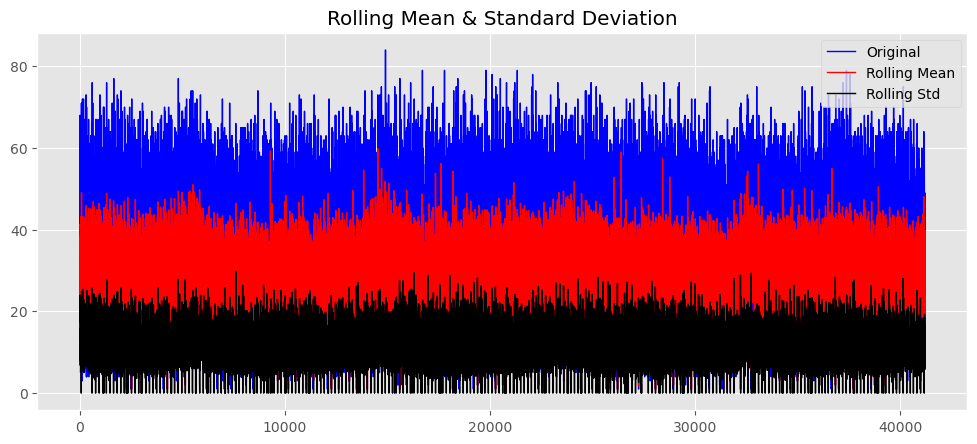

Results of Dickey-Fuller Test:
Test Statistic                   -24.639541
p-value                            0.000000
#Lags Used                        55.000000
Number of Observations Used    41169.000000
Critical Value (1%)               -3.430509
Critical Value (5%)               -2.861610
Critical Value (10%)              -2.566807
dtype: float64


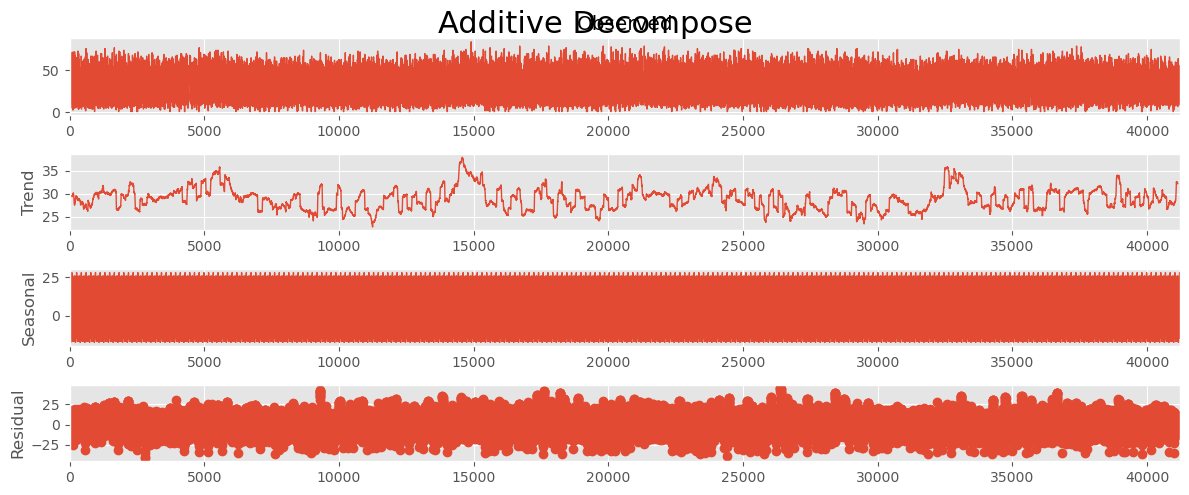

In [479]:
# Check components and stationarity of the forecast variable
forecast_variable = dataset['n_clients'].values

# Test stationarity
test_stationarity(forecast_variable)

# Additive Decomposition
result_add = seasonal_decompose(forecast_variable, model='additive', period=175)

# Plot components

result_add.plot().suptitle('Additive Decompose', fontsize=22)
pyplot.show()

In [480]:
values = dataset.values
# Encode weekday
if encode_weekday:
    encoder = LabelEncoder()
    values[:, 1] = encoder.fit_transform(values[:, 1])

# ensure all data is float
values = values.astype('float32')

print(values.shape)

(41225, 1)


In [481]:
# split into train and test, leave the last test_set blocks for n_output timesteps
train, test = values[:-test_set], values[-test_set:]  

# Normalization
scaler = StandardScaler() #MinMaxScaler(feature_range=(0, 1)) 
train = scaler.fit_transform(train)
test = scaler.transform(test)

#for walkforward
def normalize_train(scaler, train):
    train = scaler.fit_transform(train)
    return train

# restructure into windows, for the sliding window method
train = array(split(train, len(train) / data_split))
test = array(split(test, len(test) / n_output))
print(train.shape, test.shape)

(40475, 1, 1) (750, 1, 1)


In [482]:
# convert history into inputs and outputs - framing to a supervised learning problem
def to_supervised(train, n_input, n_output, stride=1):
    # flatten data
    data = train.reshape(train.shape[0] * train.shape[1], train.shape[2])
    train_x, train_y = list(), list()
    in_start = 0
    # step over the entire history one STRIDE step at a time
    for _ in range(0, len(data), stride):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_output
        # ensure we have enough data for this instance
        if out_end <= len(data):
            """
            print("iteration")
            print("x")
            print(in_start,in_end)
            print("y")
            print(in_end,out_end)
            """
            train_x.append(data[in_start:in_end, :])
            train_y.append(data[in_end:out_end, 0])
        # move along stride time steps
        in_start += stride
    print(array(train_x).shape, array(train_y).shape)
    return array(train_x), array(train_y)

In [483]:
# make the multi-step forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    #data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
    
    # retrieve last n_input observations to predict with
    data = data.reshape(data.shape[0], 1, 1)
    #print(data.shape)
    input_x = data[-n_input:]
    #print(input_x)
    
    input_x = input_x.reshape(1, input_x.shape[0], 1)
    input_x = numpy.asarray(input_x).astype('float32')
    #print(input_x.shape)
    
    # forecast the next n_output steps
    yhat = model.predict(input_x, verbose=0)
    
    # we only want the forecast variable
    yhat = yhat[0]
    return yhat

In [484]:
# invert the scaling
def invTransformTarget(scaler, data):
    dummy = pd.DataFrame(zeros((len(data), scaler.n_features_in_)))
    dummy[0] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns)
    return dummy[0].values

walkforward expanding: 0
total expansions: 0
(40450, 25, 1) (40450, 1)
Epoch 1/50
1265/1265 [==============================] - 26s 19ms/step - loss: 0.3254 - mae: 0.4347
Epoch 2/50
1265/1265 [==============================] - 24s 19ms/step - loss: 0.1970 - mae: 0.3378
Epoch 3/50
1265/1265 [==============================] - 24s 19ms/step - loss: 0.1823 - mae: 0.3250
Epoch 4/50
1265/1265 [==============================] - 25s 20ms/step - loss: 0.1748 - mae: 0.3167
Epoch 5/50
1265/1265 [==============================] - 26s 20ms/step - loss: 0.1739 - mae: 0.3143
Epoch 6/50
1265/1265 [==============================] - 25s 20ms/step - loss: 0.1638 - mae: 0.3067
Epoch 7/50
1265/1265 [==============================] - 24s 19ms/step - loss: 0.1655 - mae: 0.3075
Epoch 8/50
1265/1265 [==============================] - 24s 19ms/step - loss: 0.1652 - mae: 0.3062
Epoch 9/50
1265/1265 [==============================] - 25s 20ms/step - loss: 0.1635 - mae: 0.3040
Epoch 10/50
1265/1265 [===============

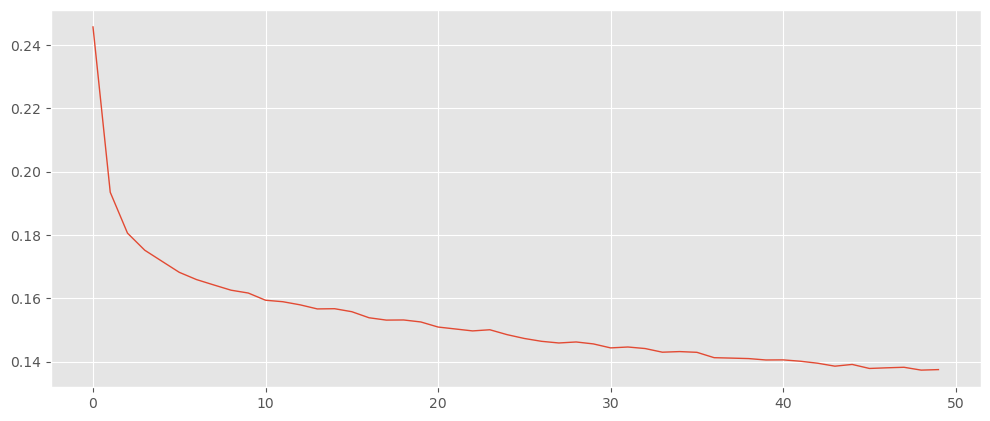

C:\Users\crash\miniconda3\envs\backup\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Test unnormalized error to compare to training loss:
0.27567307992420753
40475
The following errors are calculated without the imputed observations!

[22.43929535 24.73630475 26.03087675 31.45133105 36.73322833 41.99672407
 46.48853674 49.02420309 50.7010708  51.07183006 48.01662077 22.53374033
 24.86566976 25.7605033  31.61369272 38.27242874 41.76246718 46.99398972
 49.77906865 52.13879438 53.11112168 50.91915098 38.10445395 26.82344435
 16.29155834 12.20615377 12.14659674 12.29292415 12.95801853 13.97240176
 17.38141568 19.33654682 21.53346213 22.22360239 20.32384506 12.73549257
 22.66427659 24.94551234 25.69131521 31.68948577 39.48780529 41.21224336
 47.09489284 50.01472772 52.71517943 53.87792626 52.23356949 38.28076019
 26.94826964 16.30951647 12.22091273 12.22959229 12.3447604  12.96888208
 13.98516731 17.5062299  19.4333445  21.60040107 22.15850856 20.33257421
 12.57940235 22.82657359 25.05131583 25.61963489 31.67184124 39.99568049
 40.84113696 47.11993581 50.09133856 52.9740592

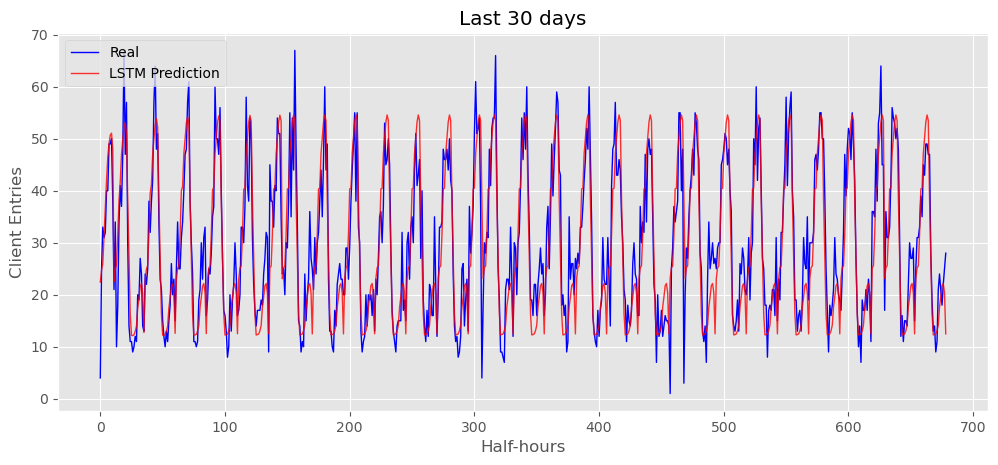

size of target and prediction:
679 679
Each n_output score, iteration 0 
RMSE 6.414426722338687
MAE 4.901488751502893
MAPE 24.831042216454975
MAAPE 18.087320545864404 

The lower visualizations are only useful if walkforward (and multiple predictions) is employed


In [485]:
#%matplotlib notebook
# history of windows, is updated for each prediction
history = [x for x in train]


# save predictions
predictions = list()
yhat_sequence = list()
# Time Series CROSS-VALIDATION
# we don't need to retrain all the time though!
print("walkforward expanding: %s" % (0))
print("total expansions: %s" % (0))
# the model is trained and retrained for every number of n_output to predict
model = build_model(array(history), n_input, n_output, stride)  
train_size = len(history) # number of training windows
len_train = train_size*n_output # actual training size/length
# predict the next n_output steps
for j in range(int(test_set)):
    yhat = forecast(model, history, n_input)
    #print(yhat.shape)
    yhat_sequence.append(yhat.item(0))
    #print(yhat_sequence)
    history.append(yhat.item(0))
    
        
print("Test unnormalized error to compare to training loss:") 
#print(array(test).shape, len(yhat_sequence))
#print(array(test[:test_set*(i+1)]).shape)
print(mean_squared_error(array(test).flatten(), yhat_sequence))
    
# invert the scaling on predictions
yhat_sequence = invTransformTarget(scaler, yhat_sequence)
    
# invert scaling for real values
test_y = invTransformTarget(scaler, array(test).flatten())
        
# store the predictions for later results
predictions.append(yhat_sequence)

if imputed:
    print(len_train)
    list_idx = []
    for idx in imputed_idx:
        if len_train-1<idx<len_train+test_set:
                list_idx.append(idx - len_train)
    if list_idx:
        yhat_sequence = numpy.delete(yhat_sequence,  list_idx)
        test_y = numpy.delete(test_y,  list_idx)  
        print("The following errors are calculated without the imputed observations!\n")
    
if compare_imputed:
    list_idx = []
    for idx in remove_idx:
        if len_train-1<idx<len_train+test_set:
            list_idx.append(idx - len_train)
    if list_idx:
        yhat_sequence = numpy.delete(yhat_sequence,  list_idx)
        test_y = numpy.delete(test_y,  list_idx) 
        print("The following errors are calculated without observations that do not fit into the wanted schedule!\n")
        print(list_idx)

# plot each iteration 
print(yhat_sequence)
pyplot.title('Last 30 days')
pyplot.plot(test_y, color="blue", label="Real")
pyplot.plot(yhat_sequence, alpha=0.8, color="red", label="LSTM Prediction")
pyplot.legend(loc="upper left")
pyplot.xlabel("Half-hours")
pyplot.ylabel("Client Entries")
pyplot.show()
    
print("size of target and prediction:")
print(len(test_y), len(yhat_sequence))
# Score only from the each modelled n_output
rmse = sqrt(mean_squared_error(test_y, yhat_sequence))
mae = mean(abs(test_y - yhat_sequence))
mape = mean(abs(test_y - yhat_sequence) / test_y) * 100
maape = mean_arctangent_absolute_percentage_error(test_y, yhat_sequence)
print('Each n_output score, iteration %s \nRMSE %s' % (0, rmse))
print('MAE %s' % (mae))
print('MAPE %s' % (mape))
print('MAAPE %s \n' % (maape))
    
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png') 
# The question mark means that first dimension is not fixed in the graph and it can vary between run calls
print("The lower visualizations are only useful if walkforward (and multiple predictions) is employed")